## Understanding the math underhood 

1. logit = z $$z=wx+b$$
2. likelihood function: $$\sigma^y(z)[1-\sigma(z)]^{1-y}$$ where $$\sigma = \frac{1}{1+e^{-z}}$$
3. log-likelihood function: $$ln(\sigma^y(z)[1-\sigma(z)]^{1-y})$$ to make math easier
4. Loss function for Logistic regression: $$-ln(\sigma^y(z)[1-\sigma(z)]^{1-y})$$
$$or$$
$$\frac{1\sum_{i=1}^m }{m}$$

## Manual practice


In [1]:
# example 1
y = 1
w = 2.0
x = 0.5
b = -0.2

# step 1: compute z 
z = w*x + b

# step 2: estimate sigmoid(z)
import math
e = math.e
sigmoid = 1/(1+e**(-z))

# step 3: compute the likelihood
likelihood = sigmoid**y *(1-sigmoid)**(1-y)

# step 4: compute the log-likelihood
import numpy as np
def ln(x):
    return np.log(x)
log_lh = ln(likelihood)
#print(log_lh)

# step 5: compute
loss = -log_lh
print(f"the loss: {loss}")

the loss: 0.37110066594777763


In [2]:
# example 2:
y = 0 
w = -1.5
x = 1.2
b = 0.3

# step 1: compute z
z = w*x+b
print(f"logit: {z}")

# step 2 compute sigmoid
sigmoid = 1/(1+e**(-z))
print(f"sigmoid: {sigmoid}")

# step 3 compute the likelihood
lh = sigmoid**y * (1-sigmoid)**(1-y)
print(f"likelihood: {lh}")

# step 4 compute the log-likelihood
log_lh = ln(lh)
print(f"the log-likelihood: {log_lh}")

# step 5 compute the loss
loss = -log_lh
print(f"the loss: {loss}")

logit: -1.4999999999999998
sigmoid: 0.18242552380635638
likelihood: 0.8175744761936437
the log-likelihood: -0.2014132779827524
the loss: 0.2014132779827524


### negative ln-likelihood = cost function for logistic regression = binary cross-entropy 

In [3]:
# exmple of interpreting 
ln_45=-np.log(0.45)
ln_45

0.7985076962177716

the output tells us that loss is very big and our model is not very good

#### practicing of calculating the loss function value over a dataset (weights are known)

In [4]:
import pandas as pd
np.random.seed(42)

w = 2.0
b = -1.0

n_samples = 100
X = np.random.randn(n_samples) 

z = w*X + b
def sigmoid(z):
    return 1/(1 + np.exp(-z))

probs = sigmoid(z)
y = np.random.binomial(1, probs)

df = pd.DataFrame({'X': X, 'prob': probs, 'y': y})
print(df.head())

          X      prob  y
0  0.496714  0.498357  0
1 -0.138264  0.218142  0
2  0.647689  0.573312  1
3  1.523030  0.885549  1
4 -0.234153  0.187200  1


In [5]:
m = len(df)
sum = 0
for i in range(m): 
    sum+= df["y"][i]*np.log(df["prob"][i]) + (1-df["y"][i])*np.log(1-df["prob"][i])
loss_val = -sum/m
print(f"the value of loss function with current weights: w = {w} and b = {b} is {loss_val}")

the value of loss function with current weights: w = 2.0 and b = -1.0 is 0.43508814398787854


**let's make a function from the code above:**

In [6]:
def loss_val(w, b, x, y):
    z = w*x + b
    probs = sigmoid(z)
    m = len(probs)
    sum = 0
    for i in range(m):
        sum += y[i]*np.log(probs[i]) + (1-y[i])*np.log(1-probs[i])
    return -sum/m
        

In [7]:
# let's test the function

lv_21 = loss_val(w, b, df["X"], df["y"])
lv_21

0.43508814398787854

the output above says that the function works 

#### now, let's test on various w and b manually:

In [8]:
w = 1.5
b = 0.2
lv = loss_val(w, b, df["X"], df["y"])
lv

0.5730380808445099

bad weights

In [9]:
w = 2.5
b = 1.5
lv = loss_val(w, b, df["X"], df["y"])
lv

0.9802465673291713

very bad weights

In [10]:
w = 1.8
b = -1.8

lv = loss_val(w, b, df["X"], df["y"])
lv

0.46343167904032156

In [11]:
w = 2.1
b = -1.8

lv = loss_val(w, b, df["X"], df["y"])
lv

0.45499222739403566

## How to find these $w$ and $b$? 

Now, the whole "train the model" means finding 

## Training the Gradient Descent on actual dataset

### Preprocessing

In [12]:
df = pd.read_csv("weather_forecast_data.csv")
print(df.head())
print(df.shape)
print(df.describe())
print(df.isnull().sum())

   Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
0    23.720338  89.592641    7.335604    50.501694  1032.378759     rain
1    27.879734  46.489704    5.952484     4.990053   992.614190  no rain
2    25.069084  83.072843    1.371992    14.855784  1007.231620  no rain
3    23.622080  74.367758    7.050551    67.255282   982.632013     rain
4    20.591370  96.858822    4.643921    47.676444   980.825142  no rain
(2500, 6)
       Temperature     Humidity   Wind_Speed  Cloud_Cover     Pressure
count  2500.000000  2500.000000  2500.000000  2500.000000  2500.000000
mean     22.581725    64.347094     9.906255    49.658104  1014.312336
std       7.326996    19.954739     5.780316    29.123104    20.196433
min      10.001842    30.005071     0.009819     0.015038   980.014486
25%      16.359398    47.339815     4.761909    23.900016   996.938630
50%      22.536448    63.920797     9.908572    49.488284  1013.433035
75%      28.976476    81.561021    14.948408    75.3241

In [13]:
print(df["Rain"])
print()
print(df["Rain"].dtype)
print(df.dtypes)

0          rain
1       no rain
2       no rain
3          rain
4       no rain
         ...   
2495    no rain
2496    no rain
2497    no rain
2498    no rain
2499    no rain
Name: Rain, Length: 2500, dtype: object

object
Temperature    float64
Humidity       float64
Wind_Speed     float64
Cloud_Cover    float64
Pressure       float64
Rain            object
dtype: object


In [14]:
# converting categorical values into binary int dtype
df["Rain"] = df["Rain"].astype("string").str.strip().str.lower().map({"rain":1, "no rain":0})
df.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,1
1,27.879734,46.489704,5.952484,4.990053,992.614190,0
2,25.069084,83.072843,1.371992,14.855784,1007.231620,0
3,23.622080,74.367758,7.050551,67.255282,982.632013,1
4,20.591370,96.858822,4.643921,47.676444,980.825142,0


In [15]:
df[["Temperature", "Humidity", "Wind_Speed", "Cloud_Cover", "Pressure"]].shape

(2500, 5)

In [22]:
# independent variables
x = df[["Temperature", "Humidity", "Wind_Speed", "Cloud_Cover", "Pressure"]]

In [23]:
# dependent variable
y = df[["Rain"]]

In [24]:
# spliting the dataset to training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
print(x_train.head())
print(x_train.shape)

      Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure
2055    10.001842  78.251648    4.980841    29.887058  1033.641741
1961    34.105244  32.844383    7.206672    94.151499  1027.991494
1864    15.240068  82.011602   10.695710    20.713915  1046.234092
2326    17.161616  76.483176   13.680669    55.915756  1041.597091
461     19.476422  93.112471    1.692415    52.228285  1028.830153
(2000, 5)


In [27]:
print(y_train)
print(y_train.shape)

      Rain
2055     0
1961     0
1864     0
2326     1
461      1
...    ...
1638     0
1095     0
1130     0
1294     0
860      0

[2000 rows x 1 columns]
(2000, 1)


In [33]:
# reshaping 
x_train = x_train.T
y_train = y_train.T


In [34]:
x_train

,2055,1961,1864,2326,461,109,1962,354,266,1545,...,1482,330,1238,466,2169,1638,1095,1130,1294,860
Temperature,10.001842,34.105244,15.240068,17.161616,19.476422,33.818725,29.522130,23.404437,17.043253,17.456145,...,10.951117,14.528774,12.144865,21.232291,26.544090,26.825253,28.974614,10.051616,10.619226,33.427926
Humidity,78.251648,32.844383,82.011602,76.483176,93.112471,62.276580,77.404213,57.201245,46.685954,91.211200,...,69.069660,54.944563,53.498144,33.905357,64.537896,91.686792,58.618211,30.573940,32.810852,91.082135
Wind_Speed,4.980841,7.206672,10.695710,13.680669,1.692415,18.923217,11.819313,9.120141,19.437548,11.231930,...,10.875507,17.435792,6.363011,18.815928,16.175928,8.058946,13.531515,9.517521,16.924988,2.555987
Cloud_Cover,29.887058,94.151499,20.713915,55.915756,52.228285,53.370971,83.902390,1.529719,45.462319,35.951571,...,82.690447,92.247170,79.290192,99.662904,56.936343,78.792732,67.976388,54.450577,79.125241,55.678875
Pressure,1033.641741,1027.991494,1046.234092,1041.597091,1028.830153,1000.595246,1044.208471,1024.694465,1043.060899,988.726038,...,986.732411,988.679816,1005.350250,1009.467306,991.332382,1039.223895,1025.789614,997.630125,1011.754684,1047.366547


In [35]:
y_train

,2055,1961,1864,2326,461,109,1962,354,266,1545,...,1482,330,1238,466,2169,1638,1095,1130,1294,860
Rain,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

In [41]:
print(x_train.shape)
x_train

(5, 2000)


array([[  10.00184249,   34.10524392,   15.24006822, ...,   10.05161589,
          10.61922645,   33.42792605],
       [  78.25164776,   32.8443828 ,   82.01160248, ...,   30.57393984,
          32.81085154,   91.08213487],
       [   4.98084118,    7.20667185,   10.6957097 , ...,    9.51752125,
          16.9249876 ,    2.55598703],
       [  29.88705781,   94.15149862,   20.713915  , ...,   54.45057688,
          79.12524072,   55.67887461],
       [1033.64174102, 1027.99149412, 1046.23409224, ...,  997.63012508,
        1011.75468407, 1047.36654726]])

In [38]:
y_train

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Gradient descent 

In [39]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [57]:
m = x_train.shape[1] # number of datapoints
n = x_train.shape[0] # number of features

W = np.zeros((n, 1))
B = 0
iterations = 100000
learning_rate = 0.0015
cost_val_list = []
for i in range(iterations):
    Z = np.dot(W.T, x_train) + B
    A = sigmoid(Z)

    # cost function
    cost = -(1/m)*np.sum(y_train*np.log(A) + (1-y_train)*np.log(1-A))

    # derivatives
    dW = (1/m)*np.dot(A-y_train, x_train.T)
    dB = (1/m)*np.sum(A-y_train)

    W = W - learning_rate*dW.T
    B = B - learning_rate*dB

    cost_val_list.append(cost)
    if i%(iterations/10) == 0:
        print("cost after ", i, "iterations is: ", cost)
print("the value of W: ", W)
print("the value of B: ", B)


cost after  0 iterations is:  0.6931471805599454


C:\Users\Nazik\AppData\Local\Temp\ipykernel_17456\4033946986.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
C:\Users\Nazik\AppData\Local\Temp\ipykernel_17456\1224714622.py:14: RuntimeWarning: divide by zero encountered in log
  cost = -(1/m)*np.sum(y_train*np.log(A) + (1-y_train)*np.log(1-A))
C:\Users\Nazik\AppData\Local\Temp\ipykernel_17456\1224714622.py:14: RuntimeWarning: invalid value encountered in multiply
  cost = -(1/m)*np.sum(y_train*np.log(A) + (1-y_train)*np.log(1-A))


cost after  10000 iterations is:  nan
cost after  20000 iterations is:  nan
cost after  30000 iterations is:  nan
cost after  40000 iterations is:  nan
cost after  50000 iterations is:  nan
cost after  60000 iterations is:  nan
cost after  70000 iterations is:  nan
cost after  80000 iterations is:  nan
cost after  90000 iterations is:  nan
the value of W:  [[-10.57471025]
 [  4.87704928]
 [ -0.07759793]
 [  3.15396258]
 [ -0.35714285]]
the value of B:  -0.033333275959190944


In [58]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

m = x_train.shape[1]  # number of data points
n = x_train.shape[0]  # number of features

W = np.zeros((n, 1))
B = 0
iterations = 100000
learning_rate = 0.0015
cost_val_list = []

for i in range(iterations):
    Z = np.dot(W.T, x_train) + B
    A = sigmoid(Z)
    A = np.clip(A, 1e-8, 1 - 1e-8)  # avoid log(0)

    cost = -(1/m)*np.sum(y_train*np.log(A) + (1 - y_train)*np.log(1 - A))

    dW = (1/m)*np.dot(A - y_train, x_train.T)
    dB = (1/m)*np.sum(A - y_train)

    W = W - learning_rate*dW.T
    B = B - learning_rate*dB

    cost_val_list.append(cost)

    if i % (iterations // 10) == 0:
        print("Cost after", i, "iterations is:", cost)

print("Final weights (W):", W)
print("Final bias (B):", B)


Cost after 0 iterations is: 0.6931471805599454
Cost after 10000 iterations is: 2.463962457199882
Cost after 20000 iterations is: 1.8873438052671991
Cost after 30000 iterations is: 1.7819567786115917
Cost after 40000 iterations is: 1.738221786168671
Cost after 50000 iterations is: 1.697433481780161
Cost after 60000 iterations is: 1.6350208507202182
Cost after 70000 iterations is: 1.612856296441588
Cost after 80000 iterations is: 1.603284785598492
Cost after 90000 iterations is: 1.6318583428402893
Final weights (W): [[-10.57515593]
 [  4.87704806]
 [ -0.07756806]
 [  3.15444029]
 [ -0.36214824]]
Final bias (B): -0.03332351064052604


In [60]:
# let's visualize 
import matplotlib.pyplot as plt

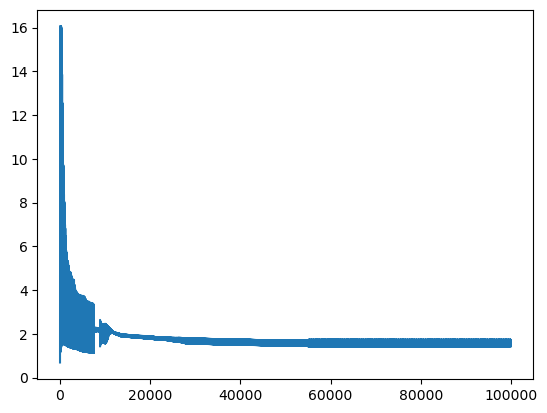

In [61]:
plt.plot(np.arange(iterations), cost_val_list)
plt.show()

### Testing accuracy

In [62]:
def accuracy(X, Y, W, B):
    
    Z = np.dot(W.T, X) + B
    A = sigmoid(Z)
    
    A = A > 0.5
    
    A = np.array(A, dtype = 'int64')
    
    acc = (1 - np.sum(np.absolute(A - Y))/Y.shape[1])*100
    
    print("Accuracy of the model is : ", round(acc, 2), "%")

In [63]:
x_test = x_test.T.to_numpy()
y_test = y_test.T.to_numpy()


In [64]:
accuracy(x_test, y_test, W, B)

Accuracy of the model is :  90.0 %


## Now let's compare with sklearn LogisticRegression()

In [78]:
from sklearn.linear_model import LogisticRegression

# Make sure y_train is 1D
model = LogisticRegression()
model.fit(x_train.T, y_train.ravel())  # x_train must be transposed if you had shape (features, samples)

# Predict
y_pred_sklearn = model.predict(x_test.T)


In [79]:
from sklearn.metrics import accuracy_score
acc_sklearn = accuracy_score(y_test.ravel(), y_pred_sklearn.ravel())

In [81]:
print("sklearn Logistic Regression Accuracy:", acc_sklearn*100, "%")

sklearn Logistic Regression Accuracy: 93.2 %
